In [9]:
import sys
sys.path.append('../')

import logging
import os
import unittest

import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt

from aad.attacks import CarliniL2V2Container
from aad.basemodels import ModelContainerPT, MnistCnnCW
from aad.utils import master_seed, get_data_path, get_l2_norm, swap_image_channel
from aad.datasets import DATASET_LIST, DataContainer

%load_ext autoreload
%autoreload 2

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [3]:
SEED = 4096
BATCH_SIZE = 32
DATA_NAME = 'MNIST'
DATA_ROOT = os.path.join('..', 'data')
MODEL_FILE = os.path.join('..', 'save', 'MnistCnnCW_MNIST_e50.pt')

In [4]:
master_seed(SEED)

In [5]:
dataset = DATASET_LIST[DATA_NAME]
dc = DataContainer(dataset, get_data_path())
dc()
model = MnistCnnCW()
mc = ModelContainerPT(model, dc)
mc.load(MODEL_FILE)
accuracy = mc.evaluate(dc.x_test, dc.y_test)
print('Accuracy on test set: {}'.format(accuracy))

INFO:aad.datasets.data_container:Train size: 60000 - Test size: 10000
INFO:aad.datasets.data_container:Successfully load data. Time to complete: 0m 4.053s
INFO:aad.basemodels.model_container_pt:Loaded model from ../save/MnistCnnCW_MNIST_e50.pt
Accuracy on test set: 0.9916


In [6]:
attack = CarliniL2V2Container(
    mc,
    targeted=False,
    learning_rate=0.01,
    binary_search_steps=9,
    max_iter=1000,
    confidence=0.0,
    initial_const=0.01,
    batch_size=32,
    clip_values=(0.0, 1.0)
)
adv, y_adv, x_clean, y_clean = attack.generate(count=100)

l2 = np.mean(get_l2_norm(adv, x_clean))
print('L2 norm: {}'.format(l2))
not_match = y_adv != y_clean
success_rate = len(not_match[not_match == True]) / len(adv)
print('Success rate: {}'.format(success_rate))

accuracy = mc.evaluate(adv, y_clean)
print('Accuracy on adv. examples: {}'.format(accuracy))

INFO:aad.attacks.carlini_l2_attack_v2:Time to complete training 100 adv. examples: 1m 13.454s
L2 norm: 9.312026023864746
Success rate: 0.86
Accuracy on adv. examples: 0.14


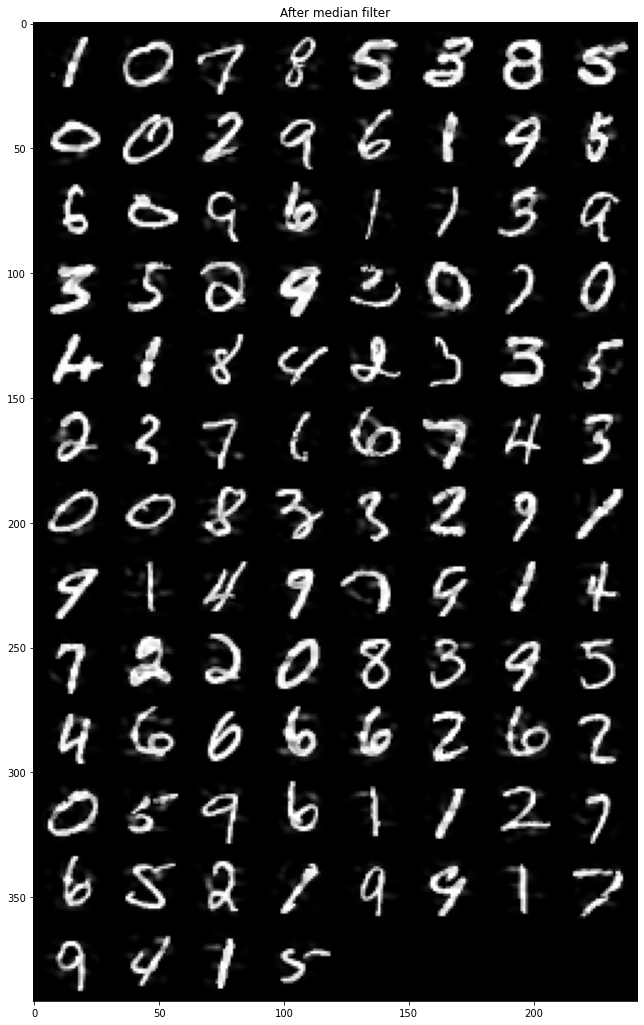

In [10]:
images = np.copy(adv)

plt.figure(figsize=[18, 18])
imshow(torch.from_numpy(swap_image_channel(images)), title='After median filter')
plt.show()